# CSCI 6998 Master's Thesis
## Chemical Element Transformations
#### Narmin Jamalova, MSCSDA 2022


> This notebook implements a Chemical Element Identifier on originally provided dataset of chemical structure images, then applies various augmentations and text position correction techniques to generate a dataset of augmented images, where chemical elements are flipped/rotated in a correct manner. 

>> The results get saved as a stand-alone dataset of augmented images with proper labelling.

## Import Libraries

In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=5ea67701b16636bc94f1d8247eeb8e559384aeb8eb1733fd83bc44c3c2ed304c
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import os
import cv2
import imutils
import numpy as np
import pandas as pd
from imutils import contours
import matplotlib.pyplot as plt
from collections import defaultdict

## Setup Dataset Directory

> For this research, the first `N_IMAGES` chemical structure images are selected from Bristol-Myers chemical structure images database. In the cell below, project directory is set up and the labels of images are read-in. The labels are standard international chemical identifiers, called InChI.

In [3]:
START    = 13001
N_IMAGES = 14000

In [4]:
# set the directory to project dataset
project_directory = '../input/bms-molecular-translation/'

# read the labels in
labels  = pd.read_csv(project_directory + 'train_labels.csv')

# restrict the labels to the first range
labels  = labels.iloc[START:N_IMAGES, :]
labels.head()

,image_id,InChI
13001,015fbe6b1701,InChI=1S/C20H20N2O3S/c1-24-17-9-6-15(7-10-17)2...
13002,015fc125c2e1,InChI=1S/C22H22N2O5/c1-13-8-9-18(14(2)10-13)23...
13003,015fc493590a,InChI=1S/C19H22N4O3S2/c1-21-12-15(10-17(21)19(...
13004,015fc992c059,"InChI=1S/C15H21ClN2O3S/c1-3-18(14-8-9-22(20,21..."
13005,015fde85594c,InChI=1S/C12H14Br2O2/c1-2-16-12-6-9(5-11(15)8-...


In [5]:
# set the directory to train dataset only
train_directory = project_directory + 'train/'

## Read Image Data

> The code below reads the image data by going through the depth of the given directory and looking for the provided image ID. The image is read in RGB mode.

In [6]:
def get_image(dir_path: str, image_id: str) -> np.array:
    """Get the image from the directory path + sub-folder pattern.
    
    :param dir_path: path to the directory in which the sub-folders are contained
    :type dir_path:  str
    :param image_id: image label
    :type image_id:  str
    :return:         read-in image
    :rtype:          np.array
    """
    img_path = (
        dir_path 
        + image_id[0] 
        + '/' 
        + image_id[1] 
        + '/' 
        + image_id[2] 
        + '/' 
        + image_id 
        + '.png'
    )
    img      = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    return img

## Normalize Image Data

> In the cell below, image pixel intensities are normalized using the MINMAX technique.

In [7]:
def get_normalized_image(img: np.array, dim: tuple = (300, 300)) -> np.array:
    """Normalize the input image pixel intensities.
    
    :param img: input image
    :type img:  np.array
    :return:    normalized image
    :rtype:     np.array
    """    
    # normalize the pixel intensities
    norm_img    = cv2.normalize(img,  (300, 300), 0, 255, cv2.NORM_MINMAX)
    
    return norm_img

## Identify Chemical Element Characters on Image Data

> In the cell below, an identifier of chemical elements is created. Its main purpose is to optically recognize textual elements on the image data and insert a red bounding box around the recognitions.

In [8]:
class ChemicalElementIdentifier():
    """Identifier of chemical elements on an image."""
    def __init__(self, img: np.array) -> None:
        """Initialize the class with input image.
        
        :param img: input image
        :type img:  np.array
        """
        self.img    = img

    def _get_processed_image(self, threshold: int = 180, kernel_size: tuple = (1, 1)) -> np.array:
        """Process the input image.
        
        In particular, apply the following transformations:
            1) gray-out the input image
            2) apply basic black-and-white thresholding
            3) dilate the image to join broken parts
            4) detect image edges using Laplace second order derivative mask
            
        :param threshold:   threshold value for black-and-white (binary) thresholding
        :type threshold:    int
        :param kernel_size: kernel size for morphological structuring (dilation)
        :type kernel_size:  tuple
        :return:            processed image
        :rtype:             np.array
        """
        # get a grayscale version of the input image
        gray_img    = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        
        # if pixel value is greater than threshold (default: 180), set it to white
        ret, mask   = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY)
        
        bitwise_img = cv2.bitwise_and(gray_img, gray_img, mask=mask)
        
        # if pixel value is greater than threshold (default: 180), set it to inverse
        ret, mask   = cv2.threshold(bitwise_img, threshold, 255, cv2.THRESH_BINARY_INV)
        
        # apply a 1x1 cross-shaped filtered dilation to increase the size of foreground objects and join broken image parts
        kernel      = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
        dilated_img = cv2.dilate(mask, kernel, iterations=9)
        
        # detect image edges using Laplace second order derivative mask
        laplace_img = cv2.Laplacian(dilated_img, cv2.CV_8U)
        
        return laplace_img
    
    
    def _get_contours(self, img: np.array) -> list:
        """Get image contours, i.e. curves that join continous parts on an image.
        
        :param img: grayscale input or processed image
        :type img:  np.array
        :return:    all contours of an image and their hierarchy
        :rtype:     list
        """
        # retrieve only the extreme outer contours and store all contour points
        contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        return contours, hierarchy
    
    
    def _get_chemical_elements_mask(
        self, 
        img:      np.array, 
        contours: np.array, 
        beta_1:   int = 20,
        beta_2:   int = 650,
        alpha:    int = 10,
    ) -> np.array:
        """Get chemical-character-only mask of an image.
        
        :param img:      a given grayscale input or processed image
        :type img:       np.array
        :param contours: overall contours of an image
        :type contours:  np.array
        :param beta_1:   lower threshold for the enclosing circle area
        :type beta_1:    int
        :param beta_2:   upper threshold for the enclosing circle area
        :type beta_2:    int
        :param alpha:    threshold for box area
        :type alpha:     int
        :return:         image chemical characters mask
        :rtype:          np.array
        """
        # initialize a list with character-only contours
        character_contours = []
        
        # function for box-side difference calculation
        # reference: https://www.kaggle.com/thomaskonstantin/letter-retrieval-molecular-translation
        box_side_diff      = lambda x: np.abs(np.linalg.norm(x[0] - x[1]) - np.linalg.norm(x[0] - x[3]))
        
        # for each contour, do
        for contour in contours:
            # find the circle covering that contour
            (x, y), radius = cv2.minEnclosingCircle(contour)
            
            # find the minimum area rotated rectangle
            rect           = cv2.minAreaRect(contour)
            
            # identify all four corner points of the rectangle, i.e. the box
            box            = cv2.boxPoints(rect)
            
            # save the contour as a character-only contour if the rule is satisfied
            # if bounding box area < alpha and circle area is between beta_1 and beta_2
            if (beta_1 < np.pi * radius**2 < beta_2) and box_side_diff(box) < alpha:
                character_contours.append(contour)
        
        # get the contoured image of the same shape as the input
        contoured_img_mask = cv2.cvtColor(np.zeros_like(img),cv2.COLOR_GRAY2RGB)
        
        # draw the contours on the contoured image
        contoured_img_mask = cv2.drawContours(contoured_img_mask, character_contours, -1, (255,255,255), 2)
        
        # gray-out the image
        contoured_img_mask = cv2.cvtColor(contoured_img_mask,cv2.COLOR_RGB2GRAY)
    
        # get the subset of the input image defined by contoured mask
        contoured_img      = cv2.bitwise_and(img, img, mask = contoured_img_mask)

        return contoured_img
    
    
    def _get_chemical_element_coordinates(self, chemical_elements_mask: np.array) -> list:
        """Get coordinates of chemical elements on an input or processed image.

        :param chemical_elements_mask: chemical-elements-only mask
        :type chemical_elements_mask:  np.array
        :return:                       list of chemical element coordinates
        :rtype:                        list
        """
        # store chemical element coordinates as tuples in this list
        coordinates         = []
        
        # get contours of the image containing chemical elements
        contours, hierarchy = self._get_contours(img=chemical_elements_mask)
        
        # get a bounding rectangle and its point coordinates around the chemical element
        for contour in contours:
            # find coordinates of the bounding rectangle
            x, y, w, h      = cv2.boundingRect(contour)
            coordinates.append((x, y, w, h))
            
        return coordinates
       
    
    def _draw_bounding_boxes_around_elements(self, img: np.array, coordinates: list) -> np.array:
        """Draw bounding boxes around the coordinates of chemical elements on a given input image.
        
        :param img:         input image
        :type img:          np.array
        :param coordinates: list of chemical element coordinates
        :type coordinates:  list
        :return:            image with bounding boxes around chemical elements
        :rtype:             np.array
        """
        img_with_boxes         = img.copy()
        for coordinate in coordinates:
            # unbundle coordinates
            x, y, w, h         = coordinate

            # draw a red bounding box around the given coordinates
            img_with_boxes = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 1)
            
        return img_with_boxes
    
    def _get_chemical_elements(self, img: np.array, coordinates: list) -> np.array:
        """Get chemical elements from a given input image.
        
        :param img:         input image
        :type img:          np.array
        :param coordinates: list of chemical element coordinates
        :type coordinates:  list
        :return:            image with an identified chemical element
        :rtype:             np.array
        """
        chemical_elements         = []
        for coordinate in coordinates:
            # unbundle coordinates
            x, y, w, h            = coordinate

            # get a chemical element using the given coordinates
            chemical_element      = img[y:y+h, x:x+w]
            chemical_elements.append(chemical_element)

        return chemical_elements

In [9]:
# read and normalize the images (using a subset of 500 images)

# store the input images here
sample_images = []

# for each image in our subset
for i in range(START, N_IMAGES):
    
    # read the image in
    img = get_image(dir_path=train_directory, image_id=labels.loc[i, 'image_id'])
    
    # normalize the image
    img = get_normalized_image(img)
    
    # store the processed image
    sample_images.append(img)

In [10]:
# get input image with bounding boxes drawn around identified chemical characters

# store individual chemical element images here
all_chemical_elements          = []

# store annotated images here (i.e. with red bounding boxes around chemical elements)
final_annotated_images         = []

# store un-annotated images here
final_unannotated_images       = []

# store coordinates of chemical elements here
all_chemical_coordinates       = []

# for each processed image 
for img in sample_images:
    
    # instantiate the chemical element identifier
    chem_identifier        = ChemicalElementIdentifier(img)
    
    # process the image
    processed_img          = chem_identifier._get_processed_image()
    
    # get contours of the processed image
    contours, hierarchy    = chem_identifier._get_contours(processed_img)
    
    # get the mask of only chemical elements
    chemical_elements_mask = chem_identifier._get_chemical_elements_mask(
        processed_img, 
        contours
    )
    
    # get the coordinates of identified chemical elements
    chemical_coordinates   = chem_identifier._get_chemical_element_coordinates(
        chemical_elements_mask
    )
    
    # get the images of chemical elements themselves
    chemical_elements      = chem_identifier._get_chemical_elements(
        img, 
        chemical_coordinates
    )
    
    # store un-annotated images
    final_unannotated_image  = img.copy()
    
    # draw bounding boxes around the chemical elements on the original image
    final_annotated_image  = chem_identifier._draw_bounding_boxes_around_elements(
        img, 
        chemical_coordinates
    )
    
    
    # store identified chemical elements
    all_chemical_elements.append(chemical_elements)
    
    # store annotated original images (i.e. with bounding boxes)
    final_annotated_images.append(final_annotated_image)
    
    # store un-annotated original images
    final_unannotated_images.append(final_unannotated_image) 
    
    # store the coordinates of chemical elements
    all_chemical_coordinates.append(chemical_coordinates)

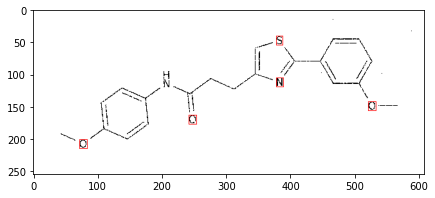

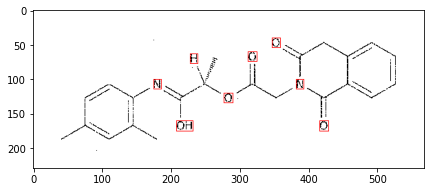

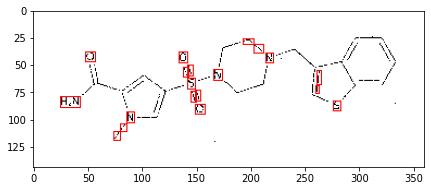

In [11]:
# view the results visually
for img in final_annotated_images[:3]:
    plt.figure(figsize=(7, 7))
    plt.imshow(img)

## Anomaly Detection

> In the code below, an anomaly detection method is suggested by going through all image data, calculating the mean and standard deviation of the identified box areas and removing the outliers. This helps get rid of false positives that sometimes get recognized by the algorithm above.

> This anomaly detection technique is based on a sample of 500 images used above for chemical element identification.

In [12]:
def compute_average_box_size(set_of_chemical_coordinates: list) -> tuple:
    """Computes the chemical element areas, their mean and standard deviation across the entire set of detected chemical elements.
    
    :param set_of_chemical_coordinates: list of all identified chemical coordinates
    :type set_of_chemical_coordinates:  list
    :return:                            computed box areas, the mean box size and standard deviation
    :rtype:                             tuple
    """
    # store all computed areas in the list below
    areas              = []
    
    # for each set of chemical coordinates, do
    for _set in set_of_chemical_coordinates:
        
        # for each coordinate in the set, do
        for coordinate in _set:
            # unravel the coordinate tuple
            x, y, w, h = coordinate
    
            # compute area
            area       = w*h
            
            # store the computed area in a container
            areas.append(area)
    
    # get the mean area size and its standard deviation
    average_box_size   = np.mean(areas)
    box_size_stdev     = np.std(areas)
    
    # normalize the areas using the mean and stdev
    areas              = [(float(idx) - average_box_size)/box_size_stdev for idx in areas]
    
    return areas, average_box_size, box_size_stdev

Average box size:  108.97965423968012 
 Standard deviation:  69.34611641748852


(array([4.370e+03, 1.618e+03, 2.102e+03, 8.300e+01, 1.420e+02, 1.670e+02,
        4.000e+00, 5.000e+00, 1.000e+01, 2.000e+00]),
 array([-1.26870341, -0.3789636 ,  0.5107762 ,  1.400516  ,  2.29025581,
         3.17999561,  4.06973541,  4.95947522,  5.84921502,  6.73895482,
         7.62869463]),
 <BarContainer object of 10 artists>)

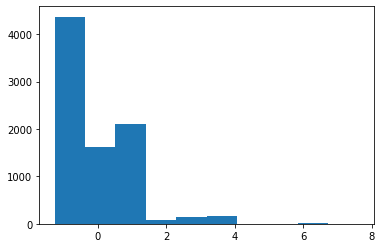

In [13]:
# compute the areas of boxes, average box size and standard deviation
areas, avg_box_size, stdev = compute_average_box_size(all_chemical_coordinates)
print('Average box size: ', avg_box_size, '\n', 'Standard deviation: ', stdev)

# plot the distribution of chemical element areas
plt.hist(areas)

## Transform Chemical Elements (with Anomaly Removal)

> Since some chemical element names change their direction upon rotations / flips (i.e. they are not symmetric), it's important to ensure that they are rotated correctly when the whole image is rotated. For example, the elements `O` and `H` will be correct regardless of the degree of rotation, but the same cannot be true for such an element as `OH`, which can transform into being `HO`, or `S` which will start looking into the opposite direction.

> In the code below, we transform images by applying rotations and flips whilst preserving the textual orientation of chemical elements. Moreover, anomaly detection technique from the code above is applied to ensure only valid boxes are considered.

> The resultant original and transformed images form a new dataset.

### Augment Image Data 

> The following augmentation techniques are applied: horizontal, vertical and two-way flips, 90 and -90 degree rotations.

In [14]:
def get_augmentations(img: np.array) -> list:
    """Get augmented images - rotations and flips.
    
    :param img:                  input image
    :type img:                   np.array
    :return:                     list of image augmentations
    :rtype:                      list
    """
    # generate flips along axes 0, 1 and both
    flip_vertical   = cv2.flip(img, 0) # vertical
    flip_horizontal = cv2.flip(img, 1) # horizontal
    flip_both_axes  = cv2.flip(img, -1) # two-way
    
    # generate rotations by 90 and 270 degrees
    rotate_90       = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rotate_270      = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # return all transformations as elements of one list
    augmentations   = [flip_vertical, flip_horizontal, flip_both_axes, rotate_90, rotate_270]
    
    return augmentations

In [15]:
# get the N_IMAGES images (since we're restarting for the purpose of augmenting)

augmented_images = {}

for i in range(START, N_IMAGES):
    # get the original image and its label
    img = get_image(dir_path=train_directory, image_id=labels.loc[i, 'image_id'])
    lbl = labels.loc[i, 'image_id']
    
    # normalize the image
    img = get_normalized_image(img)
    
    # get the image augmentations
    aug = get_augmentations(img)
    
    # append augmentations to the label key
    augmented_images[lbl] = aug

### Annotate Augmented Images (with Anomaly Detection)

In [16]:
# get input image with bounding boxes drawn around identified chemical characters

# use these dictionaries to store key-value pairs (key: InChI label, values: augmented images, elements and coordinates)
aug_chemical_elements          = {}
aug_annotated_images           = {}
aug_chemical_coordinates       = {}
aug_unannotated_images         = {}

# for each augmented image list, do
for lbl, augs in augmented_images.items():
    
    # initialization for storage dictionaries
    aug_chemical_elements[lbl]    = [0, 0, 0, 0, 0]
    aug_annotated_images[lbl]     = [0, 0, 0, 0, 0]
    aug_unannotated_images[lbl]   = [0, 0, 0, 0, 0]
    aug_chemical_coordinates[lbl] = [0, 0, 0, 0, 0]
    idx                           = 0
    
    # for each augmentation, do
    for aug in augs:
        # instantiate the chemical element identifier
        chem_identifier        = ChemicalElementIdentifier(aug)
        # pre-process the image
        processed_img          = chem_identifier._get_processed_image()
        # get image contours
        contours, hierarchy    = chem_identifier._get_contours(processed_img)
        # get the mask of only chemical elements
        chemical_elements_mask = chem_identifier._get_chemical_elements_mask(
            processed_img, 
            contours
        )
        # get coordinates of chemical elements
        chemical_coordinates   = chem_identifier._get_chemical_element_coordinates(
            chemical_elements_mask
        )
        # store non-outlier coordinates only
        updated_chem_coords    = []
        # for each coordinate, do
        for coordinate in chemical_coordinates:
            # unbundle the coordinate
            x, y, w, h         = coordinate
            # compute the area of the box
            area               = w*h
            # if the normalized area is no more than 3 stdev away, keep the element
            if (
                np.mean(areas) - 3* np.std(areas) 
                < 
                ((area - avg_box_size) / stdev) 
                < 
                np.mean(areas) + 3* np.std(areas)
            ):
                updated_chem_coords.append(coordinate)
        
        # get chemical elements separately
        chemical_elements      = chem_identifier._get_chemical_elements(
            aug, 
            updated_chem_coords
        )
        
        final_unannotated_image = aug.copy()
        
        # get final image with red bounding boxes around identified chemical elements
        final_annotated_image  = chem_identifier._draw_bounding_boxes_around_elements(
            aug, 
            updated_chem_coords
        )
        
        # update key-value pairs with final results
        aug_chemical_elements[lbl][idx]    = chemical_elements
        aug_annotated_images[lbl][idx]     = final_annotated_image  
        aug_unannotated_images[lbl][idx]   = final_unannotated_image
        aug_chemical_coordinates[lbl][idx] = updated_chem_coords
        
        idx                                +=1

### Correct Textual Orientations

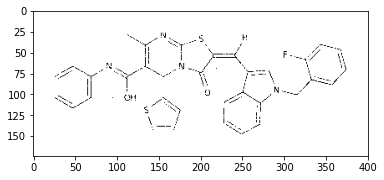

In [17]:
# showcase results on an example -- plotting the original image
im = get_image(dir_path=train_directory, image_id=lbl)
plt.imshow(im)

#### Correct the Vertical Flip (flip = 0)

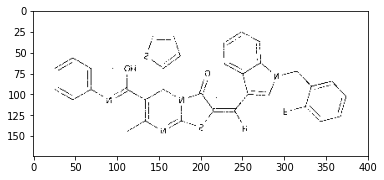

In [18]:
# show the augmented image before the correction
plt.imshow(aug_unannotated_images[lbl][0])

In [19]:
# vertical flip has index = 0 in the list of augmented images from above

# for each vertically flipped image, do
for lbl, augs in aug_unannotated_images.items():
    # for each chemical element coordinate on that image
    for idx in range(len(aug_chemical_coordinates[lbl][0])):
        # unbundle the coordinate
        x, y, w, h            = aug_chemical_coordinates[lbl][0][idx]
        # re-flip the box bounded by these coordinates
        augs[0][y:y+h, x:x+w] = cv2.flip(augs[0][y:y+h, x:x+w], 0)
        aug_unannotated_images[lbl][0] = augs[0]

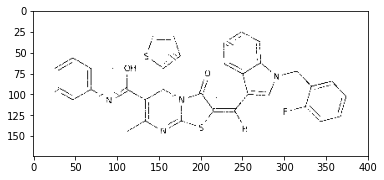

In [20]:
# display the example result
plt.imshow(aug_unannotated_images[lbl][0])

#### Correct the Horizontal Flip (flip = 1)

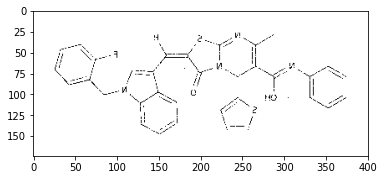

In [21]:
# show the augmented image before the correction
plt.imshow(aug_unannotated_images[lbl][1])

In [22]:
# horizontal flip has index = 1 in the list of augmented images from above

# for each horizontally flipped image, do
for lbl, augs in aug_unannotated_images.items():
    # for each chemical element coordinate on that image
    for idx in range(len(aug_chemical_coordinates[lbl][1])):
        # unbundle the coordinate
        x, y, w, h            = aug_chemical_coordinates[lbl][1][idx]
        # re-flip the box bounded by these coordinates
        augs[1][y:y+h, x:x+w] = cv2.flip(augs[1][y:y+h, x:x+w], 1)
        aug_unannotated_images[lbl][1] = augs[1]

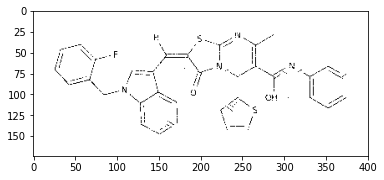

In [23]:
# display the example result
plt.imshow(aug_unannotated_images[lbl][1])

#### Correct Two-Way Flips (flip = -1)

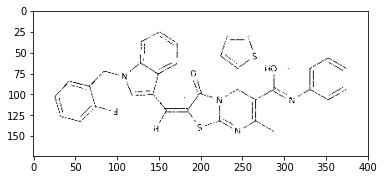

In [24]:
# show the augmented image before the correction
plt.imshow(aug_unannotated_images[lbl][2])

In [25]:
# two-way flip has index = 2 in the list of augmented images from above

# for each image flipped two-ways, do
for lbl, augs in aug_unannotated_images.items():
    # for each chemical element coordinate on that image
    for idx in range(len(aug_chemical_coordinates[lbl][2])):
        # unbundle the coordinate
        x, y, w, h            = aug_chemical_coordinates[lbl][2][idx]
        # re-flip the box bounded by these coordinates
        augs[2][y:y+h, x:x+w] = cv2.flip(augs[2][y:y+h, x:x+w], -1)
        aug_unannotated_images[lbl][2] = augs[2]

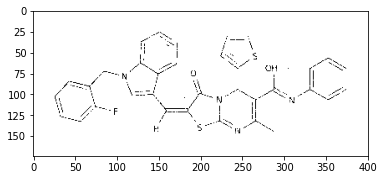

In [26]:
# display the example result
plt.imshow(aug_unannotated_images[lbl][2])

#### Correct Rotations by +90 Degrees

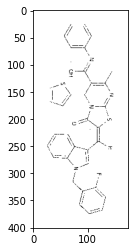

In [27]:
# show the augmented image before the correction
plt.imshow(aug_unannotated_images[lbl][3])

In [28]:
# rotation by +90 has index = 3 in the list of augmented images from above

# for each +90-rotated image, do
for lbl, augs in aug_unannotated_images.items():
    # for each chemical element coordinate on that image
    for idx in range(len(aug_chemical_coordinates[lbl][3])):
        # unbundle the coordinatees
        x, y, w, h                             = aug_chemical_coordinates[lbl][3][idx]
        # re-rotate the chemical element area
        chemical_element                       = cv2.rotate(augs[3][y:y+h, x:x+w], cv2.ROTATE_90_COUNTERCLOCKWISE)
        # get chemical element area shape
        res_width, res_height                  = chemical_element.shape[0], chemical_element.shape[1]
        # whiten the original location
        augs[3][y:y+h, x:x+w]                  = 255
        # re-insert the rotated chemical element
        try:
            augs[3][y:y+res_width, x:x+res_height] = chemical_element
        except:
            pass
        aug_unannotated_images[lbl][3] = augs[3]

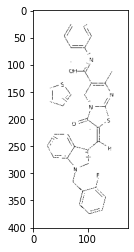

In [29]:
# display the example result
plt.imshow(aug_unannotated_images[lbl][3])

#### Correct Rotations by -90 Degrees

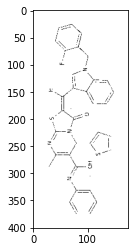

In [30]:
# show the augmented image before the correction
plt.imshow(aug_unannotated_images[lbl][4])

In [31]:
# rotation by -90 has index = 4 in the list of augmented images from above

# for each -90-rotated image, do
for lbl, augs in aug_unannotated_images.items():
    # for each chemical element coordinate on that image
    for idx in range(len(aug_chemical_coordinates[lbl][4])):
        # unbundle the coordinates
        x, y, w, h                             = aug_chemical_coordinates[lbl][4][idx]
        # re-rotate the chemical element area
        chemical_element                       = cv2.rotate(augs[4][y:y+h, x:x+w], cv2.ROTATE_90_CLOCKWISE)
        # get chemical element area shape
        res_width, res_height                  = chemical_element.shape[0], chemical_element.shape[1]
        # whiten the original location
        augs[4][y:y+h, x:x+w]                  = 255
        # re-insert the rotated chemical element
        try:
            augs[4][y:y+res_width, x:x+res_height] = chemical_element
        except:
            pass
        aug_unannotated_images[lbl][4] = augs[4]

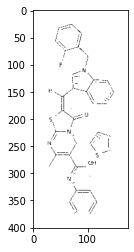

In [32]:
# display the example result
plt.imshow(aug_unannotated_images[lbl][4])

## Save the Results in a Dataset

In [33]:
# make a new directory for augmented outputs if doesn't exist
path = 'augmentations/'
try:
    os.mkdir(path)
except:
    pass

# save each augmented image as PNG under that directory
for lbl, augs in aug_unannotated_images.items():
    idx      = 0
    for aug in augs:
        cv2.imwrite(path+lbl+f'-aug{idx}.png', aug)
        idx += 1